In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.lines as mlines
from skimage import measure

In [2]:
fig_width_pt = 2*246.0  
inches_per_pt = 1.0 / 72.27
golden_mean = (np.sqrt(5) - 1.0) / 2.0
fig_width = fig_width_pt * inches_per_pt
fig_height = fig_width * golden_mean
square_size = [fig_width, fig_width]
rect_size = [fig_width, fig_height]

rc_params = {'axes.labelsize': 18,
          'axes.titlesize': 24,
          'font.size': 18,
          'legend.fontsize': 18,
          'font.family': 'serif',
          'font.sans-serif': ['Bitstream Vera Sans'],
          'font.serif': ['Bitstream Vera'],
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': True,
          'text.latex.preamble': r"""\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}""",
          'figure.figsize': rect_size,
         }
plt.rcParams.update(rc_params)

In [3]:
def Stm(f):
    A = 3
    return A**2*10**(-30)*(1 + (0.4*10**-3/f)**2)*(1 + (f/(8*10**-3))**4)*(1/(2*np.pi*f*c)**2) 
def Soms(f):
    P = 15
    return P**2*10**(-24)*(1 + (2*10**-3/f)**4)*(2*np.pi*f/c)**2

In [4]:
yearinseconds= 31557600.0
Tobs = yearinseconds*4
dof = 1000
fmin = 10**-4
fmax = 10**-2
df = dof / Tobs
freq = np.arange(fmin, fmax, df)
L = 8.3
c = 299792458.0
H02 = (69.8*1e3/ (3.08 * 1e22))**2
f0 = 10**-2.5

In [5]:
def get_contour(file, statistics = 'BF'):
    data = np.loadtxt(file)
    A , G,  BF_tot, snr, __ = data[0], data[1],  data[2], data[3], data[4]
    if statistics == 'SNR':
        rho = [10, 100, 1000]
        # Create a grid for interpolation
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]  # create a grid
        grid_c = griddata((G, A), snr, (grid_x, grid_y), method='cubic')  # interpolate values
        pls_snr_ = []
        cont_x = []
        cont_y = []
        for i in rho:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_snr_.append(np.max(pls,axis=0)*(0.67)**2)
        return pls_snr_, cont_x, cont_y
    if statistics == 'BF':
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]
        grid_c = griddata((G, A), BF_tot, (grid_x, grid_y), method='cubic')  # interpolate values
        bounds = [ 0.5, 1,  2]
        pls_bayes_10= []
        gamma_max= []
        cont_x = []
        cont_y = []
        for i in bounds:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_bayes_10.append(np.max(pls,axis=0)*(0.67)**2)
            gamma_max.append(np.argmax(pls,axis=0))
        return pls_bayes_10, cont_x, cont_y

In [6]:
pls_snr_10, x_coords, y_coords = get_contour('../../data/pls_data_nu10.txt', 'SNR')
pls_snr_10_, x_coords2, y_coords2 = get_contour('../../data/pls_data_nu8.txt', 'SNR')
pls_bayes_7, x_coords7, y_coords7 = get_contour('../../data/pls_data_nu7_2.txt')
pls_bayes_8, x_coords8, y_coords8 = get_contour('../../data/pls_data_nu8_2.txt')
pls_bayes_10, x_coords10, y_coords10  = get_contour('../../data/pls_data_nu10.txt')

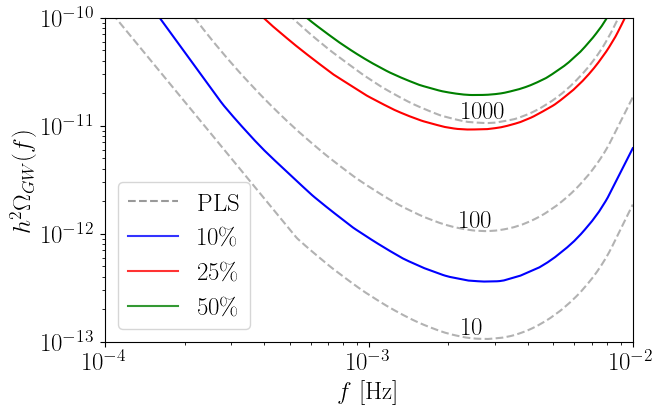

In [8]:
nu = [10, 20, 50]
bounds = [0.5, 1, 2]
rho = [10, 100, 1000]

plt.figure(figsize=rect_size)
for i in range(len(bounds)):
    if bounds[i] == 1:
        plt.loglog(freq, pls_bayes_10[i][:],'b')
        plt.loglog(freq, pls_bayes_8[i][:],'r')
        plt.loglog(freq, pls_bayes_7[i][:],'g')
for i in range(len(rho)):
    if rho[i] == 10:
        ind = np.argmin( pls_snr_10_[i][:])
        plt.loglog(freq, pls_snr_10_[i][:], 'k--',label = 'SNR = %.1f'%rho[i], alpha = 0.3)
        plt.annotate("10", xy=(freq[ind],  pls_snr_10_[i][ind]), xytext=(0.8*freq[ind], 1.1*pls_snr_10_[i][ind]))
    if rho[i] == 100:
        ind = np.argmin( pls_snr_10_[i][:])
        plt.loglog(freq, pls_snr_10_[i][:], 'k--',label = 'SNR = %.1f'%rho[i], alpha = 0.3)
        plt.annotate("100", xy=(freq[ind],  pls_snr_10_[i][ind]), xytext=(0.8*freq[ind], 1.1*pls_snr_10_[i][ind]))
    if rho[i] == 1000:
        ind = np.argmin( pls_snr_10_[i][:])
        plt.annotate("1000", xy=(freq[ind],  pls_snr_10_[i][ind]), xytext=(0.8*freq[ind], 1.1*pls_snr_10_[i][ind]))
        plt.loglog(freq, pls_snr_10_[i][:], 'k--',label = 'SNR = %.1f'%rho[i], alpha = 0.3)

ck = mlines.Line2D([], [], color='grey', alpha = 0.8, label = r'PLS', linestyle='dashed')
cb = mlines.Line2D([], [], color='b', alpha = 0.8, label = r'$10 \%$', linestyle='-')
cr = mlines.Line2D([], [], color='r', alpha = 0.8, label = r'$25 \%$', linestyle='-')
cg = mlines.Line2D([], [], color='g', alpha = 0.8, label = r'$50\%$', linestyle='-')
leg = plt.legend(handles=[ck, cb, cr, cg], loc='best')
plt.xlabel('$f$ [Hz]')
plt.ylabel(r'$h^2\Omega_{GW}(f)$')
plt.ylim(10**-13,10**-10)
plt.xlim(10**-4,10**-2)
plt.savefig('../../plots/pls_nu.pdf', bbox_inches='tight')